# Twitter 2017

In [38]:
import pandas as pd
import numpy as np
from datetime import datetime

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')  # Download the VADER lexicon
import matplotlib.pyplot as plt

import psycopg2
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Extract and organize data

In [39]:
# import data
data = pd.read_csv('Twitter/result20170101-20180101.csv',encoding='ISO-8859-1')


In [40]:
# grab fields of interest
# select the columns wanted and rename them
df_selection = data[['create_at', 'geo_tag.stateName', 'user.id', 'text']]
data = df_selection.rename(columns={
    'create_at': 'Created',
    'geo_tag.stateName': 'State',
    'user.id': 'Owner',
    'text': 'Tweet'
})
data
# gives 5608 rows

,Created,State,Owner,Tweet
0,2017-03-01 00:21:01.0,Washington,51884939,So Trump is backing off his election immigrati...
1,2017-03-01 01:57:47.0,Texas,3408800658,@RepBarbaraLee Your not the resistance! The wo...
2,2017-03-01 04:10:28.0,Arizona,67238855,@pewresearch BO said I hear you referring ...
3,2017-03-01 12:43:59.0,New Jersey,91826372,@ChrisCuomo will the Immigration Crimes Unit b...
4,2017-03-01 16:14:06.0,Nebraska,393735915,@andrewkuta4 @demkittiesdoe well he kinda rape...
...,...,...,...,...
5603,2017-11-30 03:20:06.0,Ohio,739628371177541638,@SenatorCollins @lisamurkowski @senrobportman ...
5604,2017-11-30 12:58:35.0,Massachusetts,2821648091,@tonyschwartz Would like to add conservative m...
5605,2017-11-30 17:02:28.0,Texas,805973672875950080,@SenJohnMcCain if you really gave this bill CA...
5606,2017-11-30 17:40:46.0,Colorado,802238293165412353,@JulianAssange you should come clean on Seth R...


In [41]:
# convert the states to abbrivations
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Apply the state mapping to convert the state column
data['State'] = data['State'].map(state_mapping)

# Print the updated DataFrame
data

,Created,State,Owner,Tweet
0,2017-03-01 00:21:01.0,WA,51884939,So Trump is backing off his election immigrati...
1,2017-03-01 01:57:47.0,TX,3408800658,@RepBarbaraLee Your not the resistance! The wo...
2,2017-03-01 04:10:28.0,AZ,67238855,@pewresearch BO said I hear you referring ...
3,2017-03-01 12:43:59.0,NJ,91826372,@ChrisCuomo will the Immigration Crimes Unit b...
4,2017-03-01 16:14:06.0,NE,393735915,@andrewkuta4 @demkittiesdoe well he kinda rape...
...,...,...,...,...
5603,2017-11-30 03:20:06.0,OH,739628371177541638,@SenatorCollins @lisamurkowski @senrobportman ...
5604,2017-11-30 12:58:35.0,MA,2821648091,@tonyschwartz Would like to add conservative m...
5605,2017-11-30 17:02:28.0,TX,805973672875950080,@SenJohnMcCain if you really gave this bill CA...
5606,2017-11-30 17:40:46.0,CO,802238293165412353,@JulianAssange you should come clean on Seth R...


In [42]:
# add year and office columns
data['Year'] = 2017
# Arrange columns: Move the Year and Office columns to the front
new_cols = ['Year', 'Created', 'State', 'Owner', 'Tweet']
data_2017 = data.reindex(columns=new_cols)
data_2017
# gives 5608

,Year,Created,State,Owner,Tweet
0,2017,2017-03-01 00:21:01.0,WA,51884939,So Trump is backing off his election immigrati...
1,2017,2017-03-01 01:57:47.0,TX,3408800658,@RepBarbaraLee Your not the resistance! The wo...
2,2017,2017-03-01 04:10:28.0,AZ,67238855,@pewresearch BO said I hear you referring ...
3,2017,2017-03-01 12:43:59.0,NJ,91826372,@ChrisCuomo will the Immigration Crimes Unit b...
4,2017,2017-03-01 16:14:06.0,NE,393735915,@andrewkuta4 @demkittiesdoe well he kinda rape...
...,...,...,...,...,...
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,@SenatorCollins @lisamurkowski @senrobportman ...
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,@tonyschwartz Would like to add conservative m...
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,@SenJohnMcCain if you really gave this bill CA...
5606,2017,2017-11-30 17:40:46.0,CO,802238293165412353,@JulianAssange you should come clean on Seth R...


In [43]:
# Check for duplicate rows
duplicate_rows = data_2017.duplicated()

# Print the duplicate rows
print(data_2017[duplicate_rows])

      Year                Created State               Owner   
213   2017  2017-03-07 10:01:55.0    IA           477174486  \
282   2017  2017-03-21 00:11:41.0    KY  843906376455917568   
297   2017  2017-03-23 03:59:23.0    CA           237865285   
310   2017  2017-03-26 15:12:20.0    NY           287375118   
550   2017  2017-02-06 03:47:09.0    CA            75844645   
...    ...                    ...   ...                 ...   
5586  2017  2017-11-28 14:09:10.0    MA          3843338957   
5594  2017  2017-11-29 15:07:54.0    FL  824447914835644416   
5600  2017  2017-11-29 22:37:42.0    FL  883459984410923008   
5602  2017  2017-11-30 00:56:17.0    ID           546166043   
5606  2017  2017-11-30 17:40:46.0    CO  802238293165412353   

                                                  Tweet  
213   Canada: Asylum seekers began streaming in from...  
282   @POTUS: "Since the day of my election, we've a...  
297   @oreillyfactor This is the first time since th...  
310   @KimW

In [44]:
# Remove duplicate rows
data_2017 = data_2017.drop_duplicates()

# Print the DataFrame without duplicates
data_2017
# gives 5410 rows

,Year,Created,State,Owner,Tweet
0,2017,2017-03-01 00:21:01.0,WA,51884939,So Trump is backing off his election immigrati...
1,2017,2017-03-01 01:57:47.0,TX,3408800658,@RepBarbaraLee Your not the resistance! The wo...
2,2017,2017-03-01 04:10:28.0,AZ,67238855,@pewresearch BO said I hear you referring ...
3,2017,2017-03-01 12:43:59.0,NJ,91826372,@ChrisCuomo will the Immigration Crimes Unit b...
4,2017,2017-03-01 16:14:06.0,NE,393735915,@andrewkuta4 @demkittiesdoe well he kinda rape...
...,...,...,...,...,...
5601,2017,2017-11-29 22:43:08.0,TX,128429068,Reminder: Trump Promised to Lower Taxes For th...
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,@SenatorCollins @lisamurkowski @senrobportman ...
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,@tonyschwartz Would like to add conservative m...
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,@SenJohnMcCain if you really gave this bill CA...


# Clean and process data

In [45]:
def trim_length(text):
    '''
    This method removes the repeating characters that are repeated more than 2 times
    '''
    pat = re.compile(r"(.)\1{2,}")
    return pat.sub(r"\1\1", text)

def word_correct(myStr):
    '''
    This method accepts a string and removes the meta characters from it
    '''
    myStr = str(myStr)
    pat = re.compile(r'[^a-zA-Z1-9]+')
    corrected_str = ''
    splits = myStr.split()
    for word in splits:
        word = word.strip()
        word = re.sub(pat, '', word).lower()
        word = trim_length(word)
        corrected_str = corrected_str+word+' '
    corrected_str = corrected_str.strip()
    return corrected_str

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_word(myStr):
    myStr = str(myStr)
    lemmatizer = WordNetLemmatizer()
    lst_word = nltk.word_tokenize(myStr)
    final_str=''
    for word in lst_word:
        word = lemmatizer.lemmatize(word, get_pos(word))
        final_str = final_str+word+' '

    final_str = final_str.strip()
    return final_str

data_2017['Tweet'] = data_2017['Tweet'].apply(lambda i:word_correct(i))
data_2017['Tweet'] = data_2017['Tweet'].apply(lambda i:lemmatize_word(i))
print('Done')

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\799436769.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2017['Tweet'] = data_2017['Tweet'].apply(lambda i:word_correct(i))


Done


C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\799436769.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2017['Tweet'] = data_2017['Tweet'].apply(lambda i:lemmatize_word(i))


In [46]:
# view cleaned data
data_2017

,Year,Created,State,Owner,Tweet
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...
4,2017,2017-03-01 16:14:06.0,NE,393735915,andrewkuta4 demkittiesdoe well he kinda rap hi...
...,...,...,...,...,...
5601,2017,2017-11-29 22:43:08.0,TX,128429068,reminder trump promise to low tax for the weal...
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,senatorcollins lisamurkowski senrobportman gop...
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,tonyschwartz would like to add conservative me...
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...


# Abortion Tweets

In [49]:
def extract_abortion_text(df):
    df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)
    return df

abortion_tweet_2017 = extract_abortion_text(data_2017)
abortion_tweet_2017

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\2261991524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN
4,2017,2017-03-01 16:14:06.0,NE,393735915,andrewkuta4 demkittiesdoe well he kinda rap hi...,NaN
...,...,...,...,...,...,...
5601,2017,2017-11-29 22:43:08.0,TX,128429068,reminder trump promise to low tax for the weal...,NaN
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,senatorcollins lisamurkowski senrobportman gop...,NaN
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,tonyschwartz would like to add conservative me...,NaN
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN


In [50]:
# remove NaN rows
abortion_2017 = abortion_tweet_2017[abortion_tweet_2017['Abortion'].notna()]
abortion_2017
# gives 472 rows

,Year,Created,State,Owner,Tweet,Abortion
42,2017,2017-03-07 02:20:30.0,CA,387997846,house gop defunding plan parenthood isnt any n...,parenthood
50,2017,2017-03-08 03:59:26.0,FL,361285588,wait what lie be we on today russia immigratio...,healthcare
65,2017,2017-03-11 05:26:19.0,CA,3283686031,dont do it pres trump this health care bill wi...,health
76,2017,2017-03-13 17:19:36.0,TN,1241386093,thomasismyuncle theonesoleshoe thecivilcomment...,prolife
85,2017,2017-03-14 18:54:58.0,VA,26877747,realdonaldtrump fulfill your campaign promise ...,healthcare
...,...,...,...,...,...,...
5570,2017,2017-11-26 16:37:13.0,NY,70195260,trumpism be not new it the late incarnation of...,right
5572,2017,2017-11-26 18:30:10.0,AK,739816769884291073,fraulent election let take a look at acorn pla...,parenthood
5574,2017,2017-11-26 22:46:29.0,NY,114357262,the year be 288 the gop be push a discriminato...,right
5588,2017,2017-11-28 17:07:08.0,NY,95463107,trump roy moore strategy 1 convince gop voter ...,abortion


# Feed cleaned data into VADER algo

In [52]:
# only positive and negative sentiments
def get_sentiment_scores(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' and 'compound' columns from the SentimentScores column
    df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})
    
    return df

In [53]:
# Call sentiment function
abortion_sent_2017 = get_sentiment_scores(abortion_2017)
abortion_sent_2017

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,SentimentScores
42,2017,2017-03-07 02:20:30.0,CA,387997846,house gop defunding plan parenthood isnt any n...,parenthood,"{'neg': 0.0, 'pos': 0.0}"
50,2017,2017-03-08 03:59:26.0,FL,361285588,wait what lie be we on today russia immigratio...,healthcare,"{'neg': 0.0, 'pos': 0.0}"
65,2017,2017-03-11 05:26:19.0,CA,3283686031,dont do it pres trump this health care bill wi...,health,"{'neg': 0.2, 'pos': 0.094}"
76,2017,2017-03-13 17:19:36.0,TN,1241386093,thomasismyuncle theonesoleshoe thecivilcomment...,prolife,"{'neg': 0.099, 'pos': 0.088}"
85,2017,2017-03-14 18:54:58.0,VA,26877747,realdonaldtrump fulfill your campaign promise ...,healthcare,"{'neg': 0.0, 'pos': 0.47}"
...,...,...,...,...,...,...,...
5570,2017,2017-11-26 16:37:13.0,NY,70195260,trumpism be not new it the late incarnation of...,right,"{'neg': 0.108, 'pos': 0.179}"
5572,2017,2017-11-26 18:30:10.0,AK,739816769884291073,fraulent election let take a look at acorn pla...,parenthood,"{'neg': 0.0, 'pos': 0.076}"
5574,2017,2017-11-26 22:46:29.0,NY,114357262,the year be 288 the gop be push a discriminato...,right,"{'neg': 0.0, 'pos': 0.0}"
5588,2017,2017-11-28 17:07:08.0,NY,95463107,trump roy moore strategy 1 convince gop voter ...,abortion,"{'neg': 0.055, 'pos': 0.061}"


In [54]:
# show values
abortion_sent_2017['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        57
{'neg': 0.0, 'pos': 0.1}         9
{'neg': 0.0, 'pos': 0.098}       5
{'neg': 0.095, 'pos': 0.0}       4
{'neg': 0.132, 'pos': 0.132}     3
                                ..
{'neg': 0.0, 'pos': 0.192}       1
{'neg': 0.198, 'pos': 0.158}     1
{'neg': 0.137, 'pos': 0.126}     1
{'neg': 0.223, 'pos': 0.105}     1
{'neg': 0.0, 'pos': 0.218}       1
Name: count, Length: 372, dtype: int64

In [55]:
# Extract the sentiment scores from the 'SentimentScores' column
abortion_sent_2017['Norm_Neg'] = abortion_sent_2017['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2017['Norm_Pos'] = abortion_sent_2017['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2017

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\891776313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2017['Norm_Neg'] = abortion_sent_2017['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\891776313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2017['Norm_Pos'] = abortion_sent_2017['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg

,Year,Created,State,Owner,Tweet,Abortion,SentimentScores,Norm_Neg,Norm_Pos
42,2017,2017-03-07 02:20:30.0,CA,387997846,house gop defunding plan parenthood isnt any n...,parenthood,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
50,2017,2017-03-08 03:59:26.0,FL,361285588,wait what lie be we on today russia immigratio...,healthcare,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
65,2017,2017-03-11 05:26:19.0,CA,3283686031,dont do it pres trump this health care bill wi...,health,"{'neg': 0.2, 'pos': 0.094}",0.680272,0.319728
76,2017,2017-03-13 17:19:36.0,TN,1241386093,thomasismyuncle theonesoleshoe thecivilcomment...,prolife,"{'neg': 0.099, 'pos': 0.088}",0.529412,0.470588
85,2017,2017-03-14 18:54:58.0,VA,26877747,realdonaldtrump fulfill your campaign promise ...,healthcare,"{'neg': 0.0, 'pos': 0.47}",0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
5570,2017,2017-11-26 16:37:13.0,NY,70195260,trumpism be not new it the late incarnation of...,right,"{'neg': 0.108, 'pos': 0.179}",0.376307,0.623693
5572,2017,2017-11-26 18:30:10.0,AK,739816769884291073,fraulent election let take a look at acorn pla...,parenthood,"{'neg': 0.0, 'pos': 0.076}",0.000000,1.000000
5574,2017,2017-11-26 22:46:29.0,NY,114357262,the year be 288 the gop be push a discriminato...,right,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
5588,2017,2017-11-28 17:07:08.0,NY,95463107,trump roy moore strategy 1 convince gop voter ...,abortion,"{'neg': 0.055, 'pos': 0.061}",0.474138,0.525862


# Race Tweets

In [56]:
def extract_race_text(df):
    df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE) 
    return df

# call race function
# note data_2017 will hold all columns with NaN's
race_tweet_2017 = extract_race_text(data_2017)
race_tweet_2017

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\1644560815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN
4,2017,2017-03-01 16:14:06.0,NE,393735915,andrewkuta4 demkittiesdoe well he kinda rap hi...,NaN,NaN
...,...,...,...,...,...,...,...
5601,2017,2017-11-29 22:43:08.0,TX,128429068,reminder trump promise to low tax for the weal...,NaN,NaN
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,senatorcollins lisamurkowski senrobportman gop...,NaN,NaN
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,tonyschwartz would like to add conservative me...,NaN,NaN
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN


In [57]:
race_2017 = race_tweet_2017[race_tweet_2017['Race'].notna()]
# Drop Abortion column
race_2017 = race_2017.drop('Abortion', axis=1)
race_2017
# gives 534 rows

,Year,Created,State,Owner,Tweet,Race
14,2017,2017-03-03 00:00:56.0,WI,3906398172,our diversity roundtable a postelection immigr...,diversity
19,2017,2017-03-03 18:42:13.0,NY,68584757,with election of 45 racial hatred skyrocket ha...,racial
34,2017,2017-03-05 15:23:50.0,PA,21035729,aprescute for this election the most cogent ex...,white
54,2017,2017-03-08 23:15:06.0,OH,54935490,if youre black and didnt like get out i bet 5 ...,black
55,2017,2017-03-09 03:17:23.0,IL,2334552570,from obamas election to today ive be fight for...,racial
...,...,...,...,...,...,...
5564,2017,2017-11-25 05:14:03.0,PA,3441165682,hillary thought she be go 2 win the election i...,justice
5570,2017,2017-11-26 16:37:13.0,NY,70195260,trumpism be not new it the late incarnation of...,civil
5585,2017,2017-11-28 12:43:19.0,IL,2909960504,keep em poor n destitutebribe a few party lead...,racism
5587,2017,2017-11-28 14:23:01.0,VA,4045271176,a racial comment end senator george allen rva ...,racial


In [58]:
# run Vader sentiment on race tweets
race_sent_2017 = get_sentiment_scores(race_2017)
race_sent_2017

,Year,Created,State,Owner,Tweet,Race,SentimentScores
14,2017,2017-03-03 00:00:56.0,WI,3906398172,our diversity roundtable a postelection immigr...,diversity,"{'neg': 0.0, 'pos': 0.0}"
19,2017,2017-03-03 18:42:13.0,NY,68584757,with election of 45 racial hatred skyrocket ha...,racial,"{'neg': 0.401, 'pos': 0.0}"
34,2017,2017-03-05 15:23:50.0,PA,21035729,aprescute for this election the most cogent ex...,white,"{'neg': 0.0, 'pos': 0.231}"
54,2017,2017-03-08 23:15:06.0,OH,54935490,if youre black and didnt like get out i bet 5 ...,black,"{'neg': 0.095, 'pos': 0.0}"
55,2017,2017-03-09 03:17:23.0,IL,2334552570,from obamas election to today ive be fight for...,racial,"{'neg': 0.126, 'pos': 0.0}"
...,...,...,...,...,...,...,...
5564,2017,2017-11-25 05:14:03.0,PA,3441165682,hillary thought she be go 2 win the election i...,justice,"{'neg': 0.214, 'pos': 0.164}"
5570,2017,2017-11-26 16:37:13.0,NY,70195260,trumpism be not new it the late incarnation of...,civil,"{'neg': 0.108, 'pos': 0.179}"
5585,2017,2017-11-28 12:43:19.0,IL,2909960504,keep em poor n destitutebribe a few party lead...,racism,"{'neg': 0.434, 'pos': 0.059}"
5587,2017,2017-11-28 14:23:01.0,VA,4045271176,a racial comment end senator george allen rva ...,racial,"{'neg': 0.0, 'pos': 0.0}"


In [59]:
# count race sentiment scores
race_2017['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        42
{'neg': 0.158, 'pos': 0.284}    10
{'neg': 0.181, 'pos': 0.181}     4
{'neg': 0.17, 'pos': 0.0}        3
{'neg': 0.278, 'pos': 0.0}       3
                                ..
{'neg': 0.241, 'pos': 0.248}     1
{'neg': 0.242, 'pos': 0.0}       1
{'neg': 0.157, 'pos': 0.188}     1
{'neg': 0.112, 'pos': 0.103}     1
{'neg': 0.256, 'pos': 0.066}     1
Name: count, Length: 424, dtype: int64

In [60]:
# Extract the sentiment scores from the 'SentimentScores' column
race_sent_2017['Norm_Neg'] = race_sent_2017['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2017['Norm_Pos'] = race_sent_2017['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2017.head()

,Year,Created,State,Owner,Tweet,Race,SentimentScores,Norm_Neg,Norm_Pos
14,2017,2017-03-03 00:00:56.0,WI,3906398172,our diversity roundtable a postelection immigr...,diversity,"{'neg': 0.0, 'pos': 0.0}",0.0,0.0
19,2017,2017-03-03 18:42:13.0,NY,68584757,with election of 45 racial hatred skyrocket ha...,racial,"{'neg': 0.401, 'pos': 0.0}",1.0,0.0
34,2017,2017-03-05 15:23:50.0,PA,21035729,aprescute for this election the most cogent ex...,white,"{'neg': 0.0, 'pos': 0.231}",0.0,1.0
54,2017,2017-03-08 23:15:06.0,OH,54935490,if youre black and didnt like get out i bet 5 ...,black,"{'neg': 0.095, 'pos': 0.0}",1.0,0.0
55,2017,2017-03-09 03:17:23.0,IL,2334552570,from obamas election to today ive be fight for...,racial,"{'neg': 0.126, 'pos': 0.0}",1.0,0.0


# Immigration Tweets

In [61]:
def extract_immigration_text(df):
    df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)
    return df

immigration_tweet_2017 = extract_immigration_text(data_2017)
immigration_tweet_2017

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\3914223145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN,immigration
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN,NaN
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN,immigration
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN,immigration
4,2017,2017-03-01 16:14:06.0,NE,393735915,andrewkuta4 demkittiesdoe well he kinda rap hi...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5601,2017,2017-11-29 22:43:08.0,TX,128429068,reminder trump promise to low tax for the weal...,NaN,NaN,NaN
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,senatorcollins lisamurkowski senrobportman gop...,NaN,NaN,NaN
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,tonyschwartz would like to add conservative me...,NaN,NaN,NaN
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN,NaN


In [62]:
immigration_2017 = immigration_tweet_2017[immigration_tweet_2017['Immigration'].notna()]
# Drop Abortion and Race columns
immigration_2017 = immigration_2017.drop(['Abortion', 'Race'], axis=1)
immigration_2017
# gives 765 rows

,Year,Created,State,Owner,Tweet,Immigration
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,immigration
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,immigration
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,immigration
7,2017,2017-03-02 01:11:45.0,TX,17025489,these kidsyoure use them a a prop so you can g...,immigration
8,2017,2017-03-02 04:05:04.0,AZ,67238855,foxnews johncornyn bo i hear refer to election...,immigration
...,...,...,...,...,...,...
5551,2017,2017-11-21 03:35:55.0,WI,3951191063,i hope irs put a box on our tax form for 217 w...,border
5575,2017,2017-11-27 00:37:44.0,NM,3145937325,remember alabama do not have any international...,border
5578,2017,2017-11-27 17:58:26.0,PA,169552021,realdonaldtrump a year in still talk about the...,policy
5581,2017,2017-11-28 05:06:36.0,IL,805777805183221760,realdonaldtrump when be you go to face the rap...,family


In [63]:
# run Vader sentiment on immigration tweets
immigration_sent_2017 = get_sentiment_scores(immigration_2017)
immigration_sent_2017

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,immigration,"{'neg': 0.149, 'pos': 0.06}"
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,immigration,"{'neg': 0.0, 'pos': 0.0}"
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,immigration,"{'neg': 0.179, 'pos': 0.0}"
7,2017,2017-03-02 01:11:45.0,TX,17025489,these kidsyoure use them a a prop so you can g...,immigration,"{'neg': 0.0, 'pos': 0.0}"
8,2017,2017-03-02 04:05:04.0,AZ,67238855,foxnews johncornyn bo i hear refer to election...,immigration,"{'neg': 0.158, 'pos': 0.0}"
...,...,...,...,...,...,...,...
5551,2017,2017-11-21 03:35:55.0,WI,3951191063,i hope irs put a box on our tax form for 217 w...,border,"{'neg': 0.0, 'pos': 0.147}"
5575,2017,2017-11-27 00:37:44.0,NM,3145937325,remember alabama do not have any international...,border,"{'neg': 0.051, 'pos': 0.045}"
5578,2017,2017-11-27 17:58:26.0,PA,169552021,realdonaldtrump a year in still talk about the...,policy,"{'neg': 0.081, 'pos': 0.108}"
5581,2017,2017-11-28 05:06:36.0,IL,805777805183221760,realdonaldtrump when be you go to face the rap...,family,"{'neg': 0.144, 'pos': 0.0}"


In [64]:
# count immigration sentiment scores
immigration_sent_2017['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        107
{'neg': 0.158, 'pos': 0.0}       26
{'neg': 0.151, 'pos': 0.0}       17
{'neg': 0.144, 'pos': 0.0}       14
{'neg': 0.127, 'pos': 0.0}        6
                               ... 
{'neg': 0.321, 'pos': 0.196}      1
{'neg': 0.339, 'pos': 0.0}        1
{'neg': 0.244, 'pos': 0.0}        1
{'neg': 0.218, 'pos': 0.103}      1
{'neg': 0.167, 'pos': 0.074}      1
Name: count, Length: 500, dtype: int64

In [65]:
# Extract the sentiment scores from the 'SentimentScores' column
immigration_sent_2017['Norm_Neg'] = immigration_sent_2017['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2017['Norm_Pos'] = immigration_sent_2017['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2017

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores,Norm_Neg,Norm_Pos
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,immigration,"{'neg': 0.149, 'pos': 0.06}",0.712919,0.287081
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,immigration,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,immigration,"{'neg': 0.179, 'pos': 0.0}",1.000000,0.000000
7,2017,2017-03-02 01:11:45.0,TX,17025489,these kidsyoure use them a a prop so you can g...,immigration,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
8,2017,2017-03-02 04:05:04.0,AZ,67238855,foxnews johncornyn bo i hear refer to election...,immigration,"{'neg': 0.158, 'pos': 0.0}",1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
5551,2017,2017-11-21 03:35:55.0,WI,3951191063,i hope irs put a box on our tax form for 217 w...,border,"{'neg': 0.0, 'pos': 0.147}",0.000000,1.000000
5575,2017,2017-11-27 00:37:44.0,NM,3145937325,remember alabama do not have any international...,border,"{'neg': 0.051, 'pos': 0.045}",0.531250,0.468750
5578,2017,2017-11-27 17:58:26.0,PA,169552021,realdonaldtrump a year in still talk about the...,policy,"{'neg': 0.081, 'pos': 0.108}",0.428571,0.571429
5581,2017,2017-11-28 05:06:36.0,IL,805777805183221760,realdonaldtrump when be you go to face the rap...,family,"{'neg': 0.144, 'pos': 0.0}",1.000000,0.000000


# Socioeconomic Tweets

In [66]:
def extract_socio_text(df):
    df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)
    return df

socio_tweet_2017 = extract_socio_text(data_2017)
socio_tweet_2017

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\298036309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN,immigration,NaN
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN,NaN,class
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN,immigration,NaN
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN,immigration,NaN
4,2017,2017-03-01 16:14:06.0,NE,393735915,andrewkuta4 demkittiesdoe well he kinda rap hi...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5601,2017,2017-11-29 22:43:08.0,TX,128429068,reminder trump promise to low tax for the weal...,NaN,NaN,NaN,NaN
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,senatorcollins lisamurkowski senrobportman gop...,NaN,NaN,NaN,NaN
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,tonyschwartz would like to add conservative me...,NaN,NaN,NaN,NaN
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN,NaN,middle


In [67]:
# drop NaN's
socio_2017 = socio_tweet_2017[socio_tweet_2017['Socio_Eco'].notna()]
# Drop Abortion and Race columns
socio_2017 = socio_2017.drop(['Abortion', 'Race','Immigration'], axis=1)
socio_2017
# # gives 787 rows

,Year,Created,State,Owner,Tweet,Socio_Eco
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,class
10,2017,2017-03-02 06:30:32.0,WA,163646001,nickhanauer proposal to influence election by ...,middle
41,2017,2017-03-07 00:21:44.0,IL,23352324,mexico become the pinata of the u election a t...,middle
50,2017,2017-03-08 03:59:26.0,FL,361285588,wait what lie be we on today russia immigratio...,healthcare
60,2017,2017-03-10 02:26:41.0,CA,304215742,potus so you make those promise during electio...,medicare
...,...,...,...,...,...,...
5595,2017,2017-11-29 17:19:47.0,RI,535055364,realdonaldtrump when will you go to jail for r...,justice
5596,2017,2017-11-29 19:35:37.0,MO,1963155630,wake up people realize this bill be for the ri...,net
5599,2017,2017-11-29 21:45:50.0,OH,564514111,congrats senrobportman increase tax on senior ...,medicare
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,middle


In [68]:
# run Vader sentiment on Socio_eco tweets
socio_sent_2017 = get_sentiment_scores(socio_2017)
socio_sent_2017

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,class,"{'neg': 0.0, 'pos': 0.0}"
10,2017,2017-03-02 06:30:32.0,WA,163646001,nickhanauer proposal to influence election by ...,middle,"{'neg': 0.276, 'pos': 0.096}"
41,2017,2017-03-07 00:21:44.0,IL,23352324,mexico become the pinata of the u election a t...,middle,"{'neg': 0.137, 'pos': 0.0}"
50,2017,2017-03-08 03:59:26.0,FL,361285588,wait what lie be we on today russia immigratio...,healthcare,"{'neg': 0.0, 'pos': 0.0}"
60,2017,2017-03-10 02:26:41.0,CA,304215742,potus so you make those promise during electio...,medicare,"{'neg': 0.0, 'pos': 0.247}"
...,...,...,...,...,...,...,...
5595,2017,2017-11-29 17:19:47.0,RI,535055364,realdonaldtrump when will you go to jail for r...,justice,"{'neg': 0.256, 'pos': 0.066}"
5596,2017,2017-11-29 19:35:37.0,MO,1963155630,wake up people realize this bill be for the ri...,net,"{'neg': 0.0, 'pos': 0.218}"
5599,2017,2017-11-29 21:45:50.0,OH,564514111,congrats senrobportman increase tax on senior ...,medicare,"{'neg': 0.085, 'pos': 0.386}"
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,middle,"{'neg': 0.121, 'pos': 0.071}"


In [69]:
# count immigration sentiment scores
socio_sent_2017['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        49
{'neg': 0.158, 'pos': 0.284}    10
{'neg': 0.13, 'pos': 0.0}        4
{'neg': 0.181, 'pos': 0.181}     4
{'neg': 0.0, 'pos': 0.144}       4
                                ..
{'neg': 0.127, 'pos': 0.0}       1
{'neg': 0.083, 'pos': 0.0}       1
{'neg': 0.138, 'pos': 0.119}     1
{'neg': 0.0, 'pos': 0.242}       1
{'neg': 0.103, 'pos': 0.094}     1
Name: count, Length: 591, dtype: int64

In [70]:
# Extract the sentiment scores from the 'SentimentScores' column
socio_sent_2017['Norm_Neg'] = socio_sent_2017['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2017['Norm_Pos'] = socio_sent_2017['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2017.head()

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,class,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
10,2017,2017-03-02 06:30:32.0,WA,163646001,nickhanauer proposal to influence election by ...,middle,"{'neg': 0.276, 'pos': 0.096}",0.741935,0.258065
41,2017,2017-03-07 00:21:44.0,IL,23352324,mexico become the pinata of the u election a t...,middle,"{'neg': 0.137, 'pos': 0.0}",1.000000,0.000000
50,2017,2017-03-08 03:59:26.0,FL,361285588,wait what lie be we on today russia immigratio...,healthcare,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
60,2017,2017-03-10 02:26:41.0,CA,304215742,potus so you make those promise during electio...,medicare,"{'neg': 0.0, 'pos': 0.247}",0.000000,1.000000


# All Bias groups Visualized

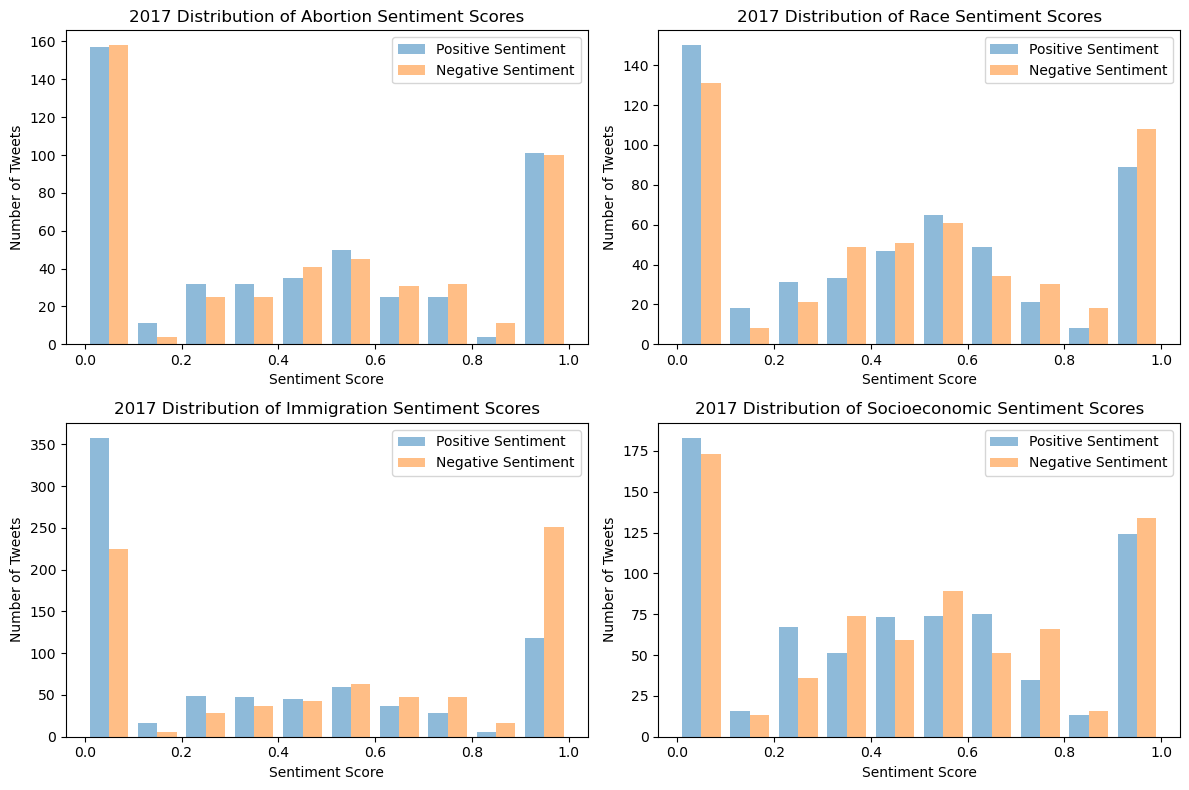

In [71]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for abortion sentiment
axes[0, 0].hist([abortion_sent_2017['Norm_Pos'], abortion_sent_2017['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Number of Tweets')
axes[0, 0].set_title('2017 Distribution of Abortion Sentiment Scores')
axes[0, 0].legend()

# Plot histogram for race sentiment
axes[0, 1].hist([race_sent_2017['Norm_Pos'], race_sent_2017['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 1].set_xlabel('Sentiment Score')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].set_title('2017 Distribution of Race Sentiment Scores')
axes[0, 1].legend()

# Plot histogram for immigration sentiment
axes[1, 0].hist([immigration_sent_2017['Norm_Pos'], immigration_sent_2017['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 0].set_xlabel('Sentiment Score')
axes[1, 0].set_ylabel('Number of Tweets')
axes[1, 0].set_title('2017 Distribution of Immigration Sentiment Scores')
axes[1, 0].legend()

# Plot histogram for socioeconomic sentiment
axes[1, 1].hist([socio_sent_2017['Norm_Pos'], socio_sent_2017['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Number of Tweets')
axes[1, 1].set_title('2017 Distribution of Socioeconomic Sentiment Scores')
axes[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Creating one table with all Bias group tags

In [72]:
data_2017
# gives 5410 rows

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN,immigration,NaN
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN,NaN,class
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN,immigration,NaN
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN,immigration,NaN
4,2017,2017-03-01 16:14:06.0,NE,393735915,andrewkuta4 demkittiesdoe well he kinda rap hi...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5601,2017,2017-11-29 22:43:08.0,TX,128429068,reminder trump promise to low tax for the weal...,NaN,NaN,NaN,NaN
5603,2017,2017-11-30 03:20:06.0,OH,739628371177541638,senatorcollins lisamurkowski senrobportman gop...,NaN,NaN,NaN,NaN
5604,2017,2017-11-30 12:58:35.0,MA,2821648091,tonyschwartz would like to add conservative me...,NaN,NaN,NaN,NaN
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN,NaN,middle


In [73]:
# Remove rows with all NaN values in 'Abortion', 'Race', 'Immigration', and 'Socio_Eco' columns
data_2017_filtered = data_2017.dropna(subset=['Abortion', 'Race', 'Immigration', 'Socio_Eco'], how='all')

# Display the filtered DataFrame
print(data_2017_filtered)

      Year                Created State               Owner   
0     2017  2017-03-01 00:21:01.0    WA            51884939  \
1     2017  2017-03-01 01:57:47.0    TX          3408800658   
2     2017  2017-03-01 04:10:28.0    AZ            67238855   
3     2017  2017-03-01 12:43:59.0    NJ            91826372   
7     2017  2017-03-02 01:11:45.0    TX            17025489   
...    ...                    ...   ...                 ...   
5595  2017  2017-11-29 17:19:47.0    RI           535055364   
5596  2017  2017-11-29 19:35:37.0    MO          1963155630   
5599  2017  2017-11-29 21:45:50.0    OH           564514111   
5605  2017  2017-11-30 17:02:28.0    TX  805973672875950080   
5607  2017  2017-11-30 19:16:43.0    NH           807740498   

                                                  Tweet Abortion     Race   
0     so trump be backing off his election immigrati...      NaN      NaN  \
1     repbarbaralee your not the resistance the work...      NaN      NaN   
2     pewres

In [74]:
# run Vader sentiment on All tweets
data_sent_2017 = get_sentiment_scores(data_2017_filtered)
data_sent_2017
# gives 3229 rows

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN,immigration,NaN,"{'neg': 0.149, 'pos': 0.06}"
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN,NaN,class,"{'neg': 0.0, 'pos': 0.0}"
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN,immigration,NaN,"{'neg': 0.0, 'pos': 0.0}"
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN,immigration,NaN,"{'neg': 0.179, 'pos': 0.0}"
7,2017,2017-03-02 01:11:45.0,TX,17025489,these kidsyoure use them a a prop so you can g...,NaN,NaN,immigration,NaN,"{'neg': 0.0, 'pos': 0.0}"
...,...,...,...,...,...,...,...,...,...,...
5595,2017,2017-11-29 17:19:47.0,RI,535055364,realdonaldtrump when will you go to jail for r...,NaN,justice,NaN,justice,"{'neg': 0.256, 'pos': 0.066}"
5596,2017,2017-11-29 19:35:37.0,MO,1963155630,wake up people realize this bill be for the ri...,debate,NaN,NaN,net,"{'neg': 0.0, 'pos': 0.218}"
5599,2017,2017-11-29 21:45:50.0,OH,564514111,congrats senrobportman increase tax on senior ...,NaN,NaN,NaN,medicare,"{'neg': 0.085, 'pos': 0.386}"
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN,NaN,middle,"{'neg': 0.121, 'pos': 0.071}"


In [75]:
# Extract the sentiment scores from the 'SentimentScores' column
data_sent_2017['Norm_Neg'] = data_sent_2017['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2017['Norm_Pos'] = data_sent_2017['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2017
# gives 1939 rows

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\453590332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2017['Norm_Neg'] = data_sent_2017['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\453590332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2017['Norm_Pos'] = data_sent_2017['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) !

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN,immigration,NaN,"{'neg': 0.149, 'pos': 0.06}",0.712919,0.287081
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN,NaN,class,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN,immigration,NaN,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN,immigration,NaN,"{'neg': 0.179, 'pos': 0.0}",1.000000,0.000000
7,2017,2017-03-02 01:11:45.0,TX,17025489,these kidsyoure use them a a prop so you can g...,NaN,NaN,immigration,NaN,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5595,2017,2017-11-29 17:19:47.0,RI,535055364,realdonaldtrump when will you go to jail for r...,NaN,justice,NaN,justice,"{'neg': 0.256, 'pos': 0.066}",0.795031,0.204969
5596,2017,2017-11-29 19:35:37.0,MO,1963155630,wake up people realize this bill be for the ri...,debate,NaN,NaN,net,"{'neg': 0.0, 'pos': 0.218}",0.000000,1.000000
5599,2017,2017-11-29 21:45:50.0,OH,564514111,congrats senrobportman increase tax on senior ...,NaN,NaN,NaN,medicare,"{'neg': 0.085, 'pos': 0.386}",0.180467,0.819533
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN,NaN,middle,"{'neg': 0.121, 'pos': 0.071}",0.630208,0.369792


In [81]:
# This function only gets the compound sentiment
def get_compound_sentiment(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' column from the SentimentScores column
    df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})
    
    return df

In [82]:
# run Vader sentiment on All tweets
data_all_sent_2017 = get_compound_sentiment(data_2017_filtered)
# Drop Sentiment Scores column
data_all_sent_2017 = data_all_sent_2017.drop(['SentimentScores'], axis=1)
data_all_sent_2017
# gives 3229 rows

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\406677615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\406677615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN,immigration,NaN,0.712919,0.287081,{'compound': -0.4654}
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN,NaN,class,0.000000,0.000000,{'compound': 0.0}
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN,immigration,NaN,0.000000,0.000000,{'compound': 0.0}
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN,immigration,NaN,1.000000,0.000000,{'compound': -0.5423}
7,2017,2017-03-02 01:11:45.0,TX,17025489,these kidsyoure use them a a prop so you can g...,NaN,NaN,immigration,NaN,0.000000,0.000000,{'compound': 0.0}
...,...,...,...,...,...,...,...,...,...,...,...,...
5595,2017,2017-11-29 17:19:47.0,RI,535055364,realdonaldtrump when will you go to jail for r...,NaN,justice,NaN,justice,0.795031,0.204969,{'compound': -0.8316}
5596,2017,2017-11-29 19:35:37.0,MO,1963155630,wake up people realize this bill be for the ri...,debate,NaN,NaN,net,0.000000,1.000000,{'compound': 0.8655}
5599,2017,2017-11-29 21:45:50.0,OH,564514111,congrats senrobportman increase tax on senior ...,NaN,NaN,NaN,medicare,0.180467,0.819533,{'compound': 0.8126}
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN,NaN,middle,0.630208,0.369792,{'compound': -0.5584}


## Final correct data frame to upload to postgresSQL

In [83]:
# Extract to compound value from the dictionary

# Update the "Compound" column
data_all_sent_2017['Compound'] = data_all_sent_2017['Compound'].apply(lambda x: x['compound'])

# Convert the "Compound" column to a numeric data type
data_all_sent_2017['Compound'] = pd.to_numeric(data_all_sent_2017['Compound'])

# Print the updated DataFrame
data_all_sent_2017
# gives 1939 rows by 12 columns

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
0,2017,2017-03-01 00:21:01.0,WA,51884939,so trump be backing off his election immigrati...,NaN,NaN,immigration,NaN,0.712919,0.287081,-0.4654
1,2017,2017-03-01 01:57:47.0,TX,3408800658,repbarbaralee your not the resistance the work...,NaN,NaN,NaN,class,0.000000,0.000000,0.0000
2,2017,2017-03-01 04:10:28.0,AZ,67238855,pewresearch bo say i hear you refer to electio...,NaN,NaN,immigration,NaN,0.000000,0.000000,0.0000
3,2017,2017-03-01 12:43:59.0,NJ,91826372,chriscuomo will the immigration crime unit be ...,NaN,NaN,immigration,NaN,1.000000,0.000000,-0.5423
7,2017,2017-03-02 01:11:45.0,TX,17025489,these kidsyoure use them a a prop so you can g...,NaN,NaN,immigration,NaN,0.000000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
5595,2017,2017-11-29 17:19:47.0,RI,535055364,realdonaldtrump when will you go to jail for r...,NaN,justice,NaN,justice,0.795031,0.204969,-0.8316
5596,2017,2017-11-29 19:35:37.0,MO,1963155630,wake up people realize this bill be for the ri...,debate,NaN,NaN,net,0.000000,1.000000,0.8655
5599,2017,2017-11-29 21:45:50.0,OH,564514111,congrats senrobportman increase tax on senior ...,NaN,NaN,NaN,medicare,0.180467,0.819533,0.8126
5605,2017,2017-11-30 17:02:28.0,TX,805973672875950080,senjohnmccain if you really give this bill car...,NaN,NaN,NaN,middle,0.630208,0.369792,-0.5584


## Load Sentiment table into PostGres
data_all_sent_2017: The single table that has all data

In [85]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    database=DATABASE,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Create a sqlalchemy engine
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

data_all_sent_2017.to_sql("twitter", engine, if_exists="append", index=False)
print("Twitter table loaded successfully")

# Commit the changes to the database
conn.commit()

# Close the database connection
conn.close()

Twitter table loaded successfully


## View the data

In [86]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to the PostgreSQL database
conn = psycopg2.connect(database=DATABASE, user=USER, password=PASSWORD, host=HOST, port=PORT)

# Query the table and store the results in a Pandas dataframe
df = pd.read_sql_query("SELECT * FROM twitter", conn)

# Print the dataframe to verify that it contains data
print(df)

# Close the database connection
conn.close()
# gives [3164 rows x 12 columns] for 2016
# [5103 rows x 12 columns] for 2017 appended

      Year                Created State               Owner   
0     2016    2016-01-03 10:33:49    TX            14649308  \
1     2016    2016-01-04 16:23:26    NH            88940328   
2     2016     2016-01-05 7:13:04    VA           359716229   
3     2016     2016-01-06 2:52:22    AZ            67238855   
4     2016    2016-01-06 15:27:19    NY            49698134   
...    ...                    ...   ...                 ...   
5098  2017  2017-11-29 17:19:47.0    RI           535055364   
5099  2017  2017-11-29 19:35:37.0    MO          1963155630   
5100  2017  2017-11-29 21:45:50.0    OH           564514111   
5101  2017  2017-11-30 17:02:28.0    TX  805973672875950080   
5102  2017  2017-11-30 19:16:43.0    NH           807740498   

                                                  Tweet  Abortion     Race   
0     deep convos after midtown about black life mat...      None    black  \
1     president bill clinton say this election will ...      None     None   
2     we 

C:\Users\Owner\AppData\Local\Temp\ipykernel_30892\1572197198.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM twitter", conn)
